In [1]:
# Created Jan 26, 2021
# Updated Jan 26, 2021

import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

import methods.sim_barcodes as sim

if True:
    with open(f'{data_dir}2/bac_lineage_positions.pkl', 'rb') as f:
        bac_lineage_positions = pickle.load(f)

    with open(f'{data_dir}2/bac_row_ids.pkl', 'rb') as f:
        bac_row_ids = pickle.load(f)

    with open(f'{data_dir}2/bac_read_arrays.pkl', 'rb') as f:
        bac_read_arrays = pickle.load(f)

    with open(f'{data_dir}2/bac_input_arrays.pkl', 'rb') as f:
        bac_input_arrays = pickle.load(f)

    with open(f'{data_dir}2/gene_meta_dict.pkl', 'rb') as f:
        bac_gene_meta_dict = pickle.load(f)

    with open(f'{data_dir}2/lineage_gene_map.pkl', 'rb') as f:
        bac_lineage_gene_map = pickle.load(f)

    with open(f'{data_dir}2/nonwu_indices.pkl', 'rb') as f:
        bac_nonwu_indices = pickle.load(f)

In [3]:
### Functions for estimating fitnesses
def rank_barcodes(freqs0, freqs1, dt=1, threshold=None):
    fitnesses = calc_lfc_array(freqs0, freqs1, dt, threshold=threshold)
    sorted_indices = np.argsort(fitnesses)[::-1] # fit to least fit
    return sorted_indices, fitnesses[sorted_indices]

def calc_lfc_array(freqs0, freqs1, dt, threshold=None):
    '''Expects dim(freqs0) = dim(freqs1)'''
    if np.any(threshold):
        mask = (np.array(freqs0)+np.array(freqs1) == 0)*(~threshold)
    else:
        mask = (np.array(freqs0)+np.array(freqs1) == 0)
    masked_freqs0 = np.ma.masked_array(freqs0, mask)
    masked_freqs1 = np.ma.masked_array(freqs1, mask)

    with np.errstate(divide='ignore'):
        return np.log( masked_freqs1/masked_freqs0 ) / dt

def threshold_large_lineages(reads0, reads1, min_reads=1):
    D0, D1 = reads0.sum(), reads1.sum()
    threshold = ((reads0/D0*D1 > min_reads) + (reads1/D1*D0 > min_reads))>0
    return threshold

def maxmin_freqs(freqs0, depth0, freqs1, depth1):
    overD0 = np.full(freqs0.shape[-1], 1/depth0)
    overD1 = np.full(freqs1.shape[-1], 1/depth1)

    min_f0 = np.min([freqs1, overD0], axis=0)
    maxmin_f0 = np.max([freqs0, min_f0], axis=0)

    min_f1 = np.min([freqs0, overD1], axis=0)
    maxmin_f1 = np.max([freqs1, min_f1], axis=0)

    return maxmin_f0, maxmin_f1

### Functions for simulating in vivo evolution
def generate_empirical_ordered_fitnesses(bac, mice, t=4):
    nonWu = bac_nonwu_indices[bac]
    read_arrays = bac_read_arrays[bac][:, nonWu]
    row_ids = bac_row_ids[bac]
    day0_freqs = read_arrays[0] / read_arrays[0].sum()

    mice_reads = read_arrays[ [row_ids[(mouse, t)] for mouse in mice ] ]
    avg_freqs = mice_reads.sum(axis=0) / mice_reads.sum()

    f0, f1 = maxmin_freqs(day0_freqs, read_arrays[0].sum(), avg_freqs, mice_reads.sum())
    lineage_indices = day0_freqs > -1

    empirical_fitnesses = calc_lfc_array(f0, f1, t)
    empirical_fitnesses[ empirical_fitnesses.mask ] = -1

    sorted_indices = np.argsort(empirical_fitnesses)[::-1]
    sorted_fitnesses = empirical_fitnesses[sorted_indices]
    sorted_indices = np.arange(lineage_indices.sum())[sorted_indices]

    return sorted_fitnesses, sorted_indices

def sim_population_frequencies(init_freqs, fitnesses, gens=4, N=1e12, D_lst=[3*10**5]*5, num_populations=5):
    population_frequencies = np.zeros((num_populations, len(init_freqs)))
    population_reads = np.zeros((num_populations, len(init_freqs)))
    for i in range(num_populations):
        pop = sim.Population(init_freqs, np.copy(fitnesses), N)
        pop.simulate(gens)

        pop.N = D_lst[i]
        pop.xs[:] = 0
        pop.simulate(1) # first poisson samplng ~ DNA extraction

        reads = pop.sample(pop.N)
        population_reads[i] = reads
        population_frequencies[i] = reads/reads.sum()
    return population_frequencies, population_reads

def generate_simulated_ordered_fitnesses(init_reads, D0, population_reads, D_tot, dt=4):
    init_freqs = init_reads / D0
    mean_pop_freqs = population_reads.sum(axis=0) / D_tot

    f0, f1 = maxmin_freqs(init_freqs, D0, mean_pop_freqs, D_tot)
    sim_fitnesses = calc_lfc_array(f0, f1, dt)

    sim_fitnesses[ sim_fitnesses.mask ] = -1
    sorted_indices = np.argsort(sim_fitnesses)[::-1]
    sim_fitnesses = sim_fitnesses[sorted_indices]
    return sim_fitnesses, sorted_indices

## functions for estimating various regression quantities

# def estimate_delta_freq_variance_err_ratio(freqs):
#     delta_freq_vars = []
#     for i in range(freqs.shape[0]):
#         freqs1 = freqs[i]
#         for j in range(i, freqs.shape[0]):
#             freqs2 = freqs[j]
#             delta_freq_var = calculate_delta_freq_variance(freqs1, freqs2)
#             delta_freq_vars.append(delta_freq_var)
#     return np.std(delta_freq_vars, ddof=1) / np.mean(delta_freq_vars)
#
# def estimate_mean_freq_err_ratio(freqs):
#     freq_means = []
#     for i in range(freqs.shape[0]):
#         freq_mean = np.mean(freqs[i])
#         freq_means.append( freq_mean )
#     return np.std(freq_means, ddof=1) / np.mean(freq_means)
#
# def estimate_selection_g_err_ratio(f0, freqs):
#     selection_g_numerators = []
#     for i in range(freqs.shape[0]):
#         g_numerator = calculate_selection_g(f0, freqs[i])
#         selection_g_numerators.append(g_numerator)
#     return np.std(selection_g_numerators, ddof=1) / np.mean(selection_g_numerators)

### estimators

def bootstrap_mean(freqs):
    bootstrap_samples = []
    z = np.arange(freqs.shape[-1])
    for i in range(1000):
        bootstrap = rnd.choice(z, len(z), replace=True)
        bootstrap_samples.append( np.mean(freqs[bootstrap]) )
    return np.mean(freqs), np.std(bootstrap_samples)

def calculate_selection_g(f0, freqs, average=True, bootstrap=False):
    if not bootstrap:
        fold_change = freqs/f0
        with np.errstate(divide='ignore'):
            log_fold_change = np.log(fold_change)

        if average:
            numerator = np.mean( f0*fold_change*(fold_change-1)/log_fold_change )
        else:
            numerator = f0*fold_change*(fold_change-1)/log_fold_change
        return numerator
    else:
        fold_change = freqs/f0
        with np.errstate(divide='ignore'):
            log_fold_change = np.log(fold_change)

        numerator = np.mean( f0*fold_change*(fold_change-1)/log_fold_change )
        bootstrap_err = bootstrap_selection_g(f0, freqs)

        return numerator, bootstrap_err

def calculate_freq_variance(freqs, average=True, bootstrap=False):
    if not bootstrap:
        if average:
            return np.mean( np.var(freqs, axis=0, ddof=1) )
        else:
            return np.var(freqs, axis=0, ddof=1)
    else:
        var = np.mean( np.var(freqs, axis=0, ddof=1) )
        bootstrap_err = bootstrap_freq_variance_err(freqs)
        return var, bootstrap_err

def calculate_delta_freq_variance(freqs1, freqs2, average=True, bootstrap=False):
    # return np.var( (freqs1 - freqs2), ddof=1 )
    if not bootstrap:
        if average:
            return np.mean( (freqs1-freqs2)**2 )
        else:
            return (freqs1-freqs2)**2
    else:
        var = np.mean( (freqs1-freqs2)**2 )
        bootstrap_err = bootstrap_delta_freq_variance_err(freqs1, freqs2)
        return var, bootstrap_err

def bootstrap_selection_g(f0, freqs):
    z = np.arange(freqs.shape[-1])
    bootstrap_samples = []
    for i in range(1000):
        bootstrap = rnd.choice(z, len(z), replace=True)
        bootstrap_freqs = freqs[bootstrap]
        bootstrap_sample = calculate_selection_g(f0[bootstrap], bootstrap_freqs, average=True, bootstrap=False)
        bootstrap_samples.append(bootstrap_sample)
    return(np.std(bootstrap_samples))

def bootstrap_freq_variance_err(freqs):
    z = np.arange(freqs.shape[-1])
    pop_var = []
    for i in range(1000):
        bootstrap = rnd.choice(z, len(z), replace=True)
        bootstrap_freqs = freqs[:, bootstrap]
        bootstrap_var = calculate_freq_variance(bootstrap_freqs, average=True, bootstrap=False)
        pop_var.append(bootstrap_var)
    return(np.std(pop_var))

def bootstrap_delta_freq_variance_err(freqs1, freqs2):
    z = np.arange(freqs1.shape[-1])
    pop_var = []
    for i in range(1000):
        bootstrap = rnd.choice(z, len(z), replace=True)
        bootstrap1, bootstrap2 = freqs1[bootstrap], freqs2[bootstrap]
        bootstrap_var = calculate_delta_freq_variance(bootstrap1, bootstrap2, average=True, bootstrap=False)
        pop_var.append(bootstrap_var)
    return(np.std(pop_var))

### lineage (barcode) groupings
def fit_individual_lineages(init_freqs, mice_reads, D_arr, splits=(2,1)):
    group_1 = mice_reads[:splits[0]]
    group_2 = mice_reads[splits[0]:splits[0]+splits[1]]
    group_3 = mice_reads[splits[0]+splits[1]:]

    # group 1 = var
    group_1 = np.einsum('ij, i->ij', group_1, D_arr[:splits[0]]**-1.)
    if splits[0] == 2:
        var_freqs = (group_1[0] - group_1[1])**2
    else:
        var_freqs = np.var(group_1, axis=0, ddof=1)

    # group 2 = e^(st)(e^(st)-1)/st
    group_2 = group_2.sum(axis=0) / D_arr[splits[0]:splits[0]+splits[1]].sum()
    fold_change = group_2 / init_freqs
    where_finite = fold_change > 0
    log_fold_change = np.log(fold_change[where_finite])
    g_estimator =  fold_change[where_finite]*(fold_change[where_finite]-1)/log_fold_change

    mean_freqs = group_3.sum(axis=0) / D_arr[splits[0]+splits[1]:].sum()

    y = var_freqs[where_finite]
    x1 = g_estimator * init_freqs[where_finite]
    x2 = mean_freqs[where_finite]

    popt, pcov = fit_weighted_multiple_regression(x1, x2, y, [], weighted=False)
    return where_finite.sum(), popt, pcov

def group_lineages_across_freq_ranges(init_freqs, init_freq_ranges, mean_freqs, start=0, min_group_size=100, min_freq_ratio=0.5):
    lineage_indices = np.arange(init_freqs.shape[-1])

    lineage_group_indices= []
    for (freq_min, freq_max) in init_freq_ranges:
        lineage_bool = (init_freqs >= freq_min) * (init_freqs < freq_max)
        fr_lineage_bools = group_lineages(init_freqs[lineage_bool], mean_freqs[lineage_bool],
                                          start=start, min_group_size=min_group_size, min_freq_ratio=min_freq_ratio)

        fr_lineage_indices = lineage_indices[lineage_bool]
        for (i1, i2) in fr_lineage_bools:
            lineage_group_indices.append(fr_lineage_indices[i1:i2])
    return lineage_group_indices

def group_lineages(f0, mean_freqs, start=0, min_group_size=100, min_freq_ratio=0.5):
    lineage_bool_ranges = []
    fold_changes = mean_freqs / f0
    while start < fold_changes.shape[-1]:
        max_fc = fold_changes[start]
        if max_fc < 1:
            break
        try:
            end = np.where( fold_changes/max_fc > min_freq_ratio)[0][-1]
            if end - start < min_group_size:
                start += 1
                continue
        except:
            start += 1
            continue

        lineage_bool_ranges.append((start, end))
        start = end+1
    return lineage_bool_ranges

def calc_estimators_in_groups(init_freqs, rep_reads, D1_arr, group_lineage_indices, splits=(2,1)):
    x1 = []
    x1_err = []
    x2 = []
    x2_err = []
    y = []
    y_err = []
    num_lineages = []

    var_freqs = np.einsum('ij, i->ij', rep_reads[:splits[0]], D1_arr[:splits[0]]**-1.)
    x1_freqs = rep_reads[splits[0]:splits[0]+splits[1]].sum(axis=0) / D1_arr[splits[0]:splits[0]+splits[1]].sum()
    x2_freqs = rep_reads[splits[0]+splits[1]:].sum(axis=0) / D1_arr[splits[0]+splits[1]:].sum()

    for group_indices in group_lineage_indices:
        freqs0 = init_freqs[group_indices]

        if splits[0] == 2:
            df_var, df_var_err = calculate_delta_freq_variance(var_freqs[0][group_indices], var_freqs[1][group_indices], bootstrap=True)
        else:
            df_var, df_var_err = calculate_freq_variance(var_freqs[:, group_indices], bootstrap=True)

        mean_freq, mean_err = bootstrap_mean(x2_freqs[group_indices])
        g_numerator, g_err = calculate_selection_g(freqs0, x1_freqs[group_indices], bootstrap=True)

        if np.isnan(mean_freq) or np.isnan(g_numerator) or np.isnan(df_var):
            continue

        x1.append(g_numerator)
        x1_err.append(g_err)
        x2.append(mean_freq)
        x2_err.append(mean_err)
        y.append(df_var)
        y_err.append(df_var_err)
        num_lineages.append( len(group_indices) )

    return [x1, x1_err, x2, x2_err, y, y_err], num_lineages

def fit_weighted_multiple_regression(x1, x2, y, y_err, weighted=True):
    if weighted:
        popt, pcov = scipy.optimize.curve_fit(lin_2var, [x1, x2], y, sigma=y_err, p0=(10**-5, 10**-5))
    else:
        popt, pcov = scipy.optimize.curve_fit(lin_2var, [x1, x2], y, p0=(10**-5, 10**-5))
    return popt, pcov

import scipy.odr as odr
def odr_regression(x1, x1_err, x2, x2_err, y, y_err, beta0=[10**-5, 10**-5]):
    def f(beta, x):
        return beta[0]*x[0] + beta[1]*x[1]
    linear = odr.Model(f)

    x = np.array([x1, x2])
    x_err = np.array([x1_err, x2_err])

    data = odr.RealData(x, y, sx=x_err, sy=y_err)
    myodr = odr.ODR(data, linear, beta0=beta0)
    output = myodr.run()
    return output

def lin_2var(x, a, b):
    x1, x2 = x
    return a*x1 + b*x2

def lin_1var(x, a):
    return a*x

def lin(x, a, b):
    return a*x + b

In [252]:
Ntau_lst = [10**5, 10**6, 10**7, 10**8, 10**9]

grouped_odr_dict = {bac:{N: {} for N in Ntau_lst} for bac in bacteria}
grouped_weighted_drift_dict = {bac:{N: {} for N in Ntau_lst} for bac in bacteria}
grouped_weighted_threshold_x_drift_dict = {bac:{N: {} for N in Ntau_lst} for bac in bacteria}
grouped_drift_dict = {bac:{N: {} for N in Ntau_lst} for bac in bacteria}
individual_drift_dict = {bac:{N: {} for N in Ntau_lst} for bac in bacteria}

mice = [1, 2, 3, 5, 6, 7, 8, 9, 10]
day = 4
tau = 1/10
splits = (2, 4)
min_group_size = 50
min_freq_ratio = 0.7

err_threshold = 0.3

for Ntau in Ntau_lst[:]:
    for bac in bacteria[:]:
        print(f'Simulating {bac} at N={Ntau}')
        if 'load empirical bac':
            nonWu = bac_nonwu_indices[bac]
            read_array = bac_read_arrays[bac][:, nonWu]
            row_ids = bac_row_ids[bac]
            D_lst = read_array[ [row_ids[(mouse, day)] for mouse in mice] ].sum(axis=1)
            init_reads = read_array[0]
            D0 = init_reads.sum()
            init_freqs = read_array[0] / read_array[0].sum()

            read_ranges = []
            read_min = 100 #
            while read_min < np.max(init_reads):
                read_max = read_min*1.20
                read_ranges.append( (read_min, read_max) )
                read_min = read_max
            init_freq_ranges = np.array(read_ranges)/init_reads.sum()
            mask = init_freqs > 10**-6

        if 'simulate at Ntau':
            fitnesses, sorted_indices = generate_empirical_ordered_fitnesses(bac, mice, day)

            num_replicates = 9
            mice_freqs, mice_reads = sim_population_frequencies(init_freqs, fitnesses*tau, gens=int(4/tau), N=Ntau/tau,
                                                       num_populations=num_replicates, D_lst=D_lst)
            inferred_fitnesses, sorted_indices = generate_simulated_ordered_fitnesses(init_freqs[mask], D0, mice_reads[:, mask], D_lst.sum(), 4)

            mice_reads = mice_reads[:, mask][:, sorted_indices]
            mice_freqs = mice_freqs[:, mask][:, sorted_indices]
            init_reads = init_reads[mask][sorted_indices]
            init_freqs = init_freqs[mask][sorted_indices]

        if 'generate groups':
            mean_freqs = mice_reads.sum(axis=0) / D_lst.sum()
            lineage_group_indices = group_lineages_across_freq_ranges(init_freqs, init_freq_ranges, mean_freqs,
                                                                      min_group_size=min_group_size, min_freq_ratio=min_freq_ratio)
            print(len(lineage_group_indices))

        for i in range(8):
            for j in range(i+1,9):
                print((i,j))
                remainder = [k for k in range(9) if k not in [i,j]]
                permutations = []
                while len(permutations) < 3:
                    permutation = rnd.permutation(remainder)
                    if set(permutation[:splits[1]]) in [set(p[:splits[1]]) for p in permutations]:
                        continue
                    permutations.append(permutation)

                for permutation in permutations:
                    order = [i, j] + list(permutation)
                    reads = mice_reads[order]
                    D_arr = D_lst[order]
                    ### fit individual lineages
                    num_lineages_fit, popt, pcov = fit_individual_lineages(init_freqs, reads, D_arr, splits=splits)
                    individual_drift_dict[bac][Ntau][tuple(order)] = (num_lineages_fit, num_lineages_fit, popt, pcov)

                    ### generate grouped lineages
                    estimators, total_lineages = calc_estimators_in_groups(init_freqs, reads, D_arr, lineage_group_indices, splits=splits)

                    tot_lineages = np.sum(total_lineages)
                    x1, x1_err, x2, x2_err, y, y_err = estimators
                    num_groups = len(x1)

                    if num_groups < 3:
                        popt, pcov = np.full(2, np.nan), np.full((2,2), np.nan)
                        grouped_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, -1, popt, pcov)
                        grouped_weighted_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, -1, popt, pcov)
                        grouped_weighted_threshold_x_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, -1, popt, pcov)
                        grouped_odr_dict[bac][Ntau][tuple(order)] = (tot_lineages, -1, popt, pcov)
                        continue

                    ### fit without weighting
                    popt, pcov = fit_weighted_multiple_regression(x1,x2,y,y_err, weighted=False)
                    grouped_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, num_groups, popt, pcov)

                    ### fit with y-weighting
                    popt, pcov = fit_weighted_multiple_regression(x1,x2,y,y_err, weighted=True)
                    grouped_weighted_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, num_groups, popt, pcov)

                    ### fit with ODR regression
                    output = odr_regression(*estimators)
                    grouped_odr_dict[bac][Ntau][tuple(order)] = (tot_lineages, num_groups, output.beta, output.cov_beta)

                    ### fit with y-weighting and thresholding error on x
                    include = []
                    for k in range(len(estimators[0])):
                        if x1_err[k] / x1[k] > err_threshold or x2_err[k] / x2[k] > err_threshold:
                            continue
                        include.append(k)

                    num_groups = len(include)
                    tot_lineages = np.array(total_lineages)[include].sum()
                    x1 = np.array(x1)[include]
                    x2 = np.array(x2)[include]
                    y = np.array(y)[include]
                    y_err = np.array(y_err)[include]
                    if len(x1) < 3:
                        popt, pcov = np.full(2, np.nan), np.full((2,2), np.nan)
                        grouped_weighted_threshold_x_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, -1, popt, pcov)
                        continue

                    popt, pcov = fit_weighted_multiple_regression(x1, x2, y, y_err, weighted=True)
                    grouped_weighted_threshold_x_drift_dict[bac][Ntau][tuple(order)] = (tot_lineages, num_groups, popt, pcov)

            # names = ['odr_dict', 'weighted_dict', 'weighted_threshold_dict', 'unweighted_dict', 'individual_dict']
            # for name, d in zip(names, [grouped_odr_dict, grouped_weighted_drift_dict, grouped_weighted_threshold_x_drift_dict, grouped_drift_dict, individual_drift_dict]):
            #     with open(f'{name}.pkl', 'wb') as f:
            #         pickle.dump(d, f)

Simulating BWH2 at N=100000
93
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(5, 6)
(5, 7)
(5, 8)
(6, 7)
(6, 8)
(7, 8)
Simulating Bovatus at N=100000
82
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(5, 6)
(5, 7)
(5, 8)
(6, 7)
(6, 8)
(7, 8)
Simulating BtVPI at N=100000
71
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(5, 6)
(5, 7)
(5, 8)
(6, 7)
(6, 8)
(7, 8)
Simulating Bt7330 at N=100000
50
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(2, 3)
(2

In [2]:
names = ['odr_dict', 'weighted_dict', 'weighted_threshold_dict', 'unweighted_dict', 'individual_dict']
# for name, d in zip(names, [grouped_odr_dict, grouped_weighted_drift_dict, grouped_weighted_threshold_x_drift_dict, grouped_drift_dict, individual_drift_dict]):
with open(f'odr_dict.pkl', 'rb') as f:
    odr9 = pickle.load(f)

with open(f'weighted_dict.pkl', 'rb') as f:
    weighted9 = pickle.load(f)

with open(f'weighted_threshold_dict.pkl', 'rb') as f:
    weighted_threshold9 = pickle.load(f)

with open(f'unweighted_dict.pkl', 'rb') as f:
    unweighted9 = pickle.load(f)

with open(f'individual_dict.pkl', 'rb') as f:
    individual9 = pickle.load(f)

with open(f'empirical_odr_dict.pkl', 'rb') as f:
    emp_odr9 = pickle.load(f)

with open(f'empirical_weighted_dict.pkl', 'rb') as f:
    emp_weighted9 = pickle.load(f)

with open(f'empirical_weighted_threshold_dict.pkl', 'rb') as f:
    emp_weighted_threshold9 = pickle.load(f)

with open(f'empirical_unweighted_dict.pkl', 'rb') as f:
    emp_unweighted9 = pickle.load(f)

with open(f'empirical_individual_dict.pkl', 'rb') as f:
    emp_individual9 = pickle.load(f)

In [30]:
bac_colors={'BWH2':KELLY_COLORS[0],
            'BtVPI':KELLY_COLORS[1],
            'Bovatus':KELLY_COLORS[2],
            'Bt7330':KELLY_COLORS[3]}
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(f'{plot_dir}/paper_figures/drift_sims.pdf') as pdf:
    for Ntau in [10**5, 10**6, 10**7, 10**8]:
        fig, axs = plt.subplots(4, figsize=(3, 6))
        for d, (drift_dict, title) in enumerate([(individual9, 'INDIVIDUAL'), (unweighted9, 'GROUPED'), (weighted9, 'GROUPED\n+WEIGHTED'), (odr9, 'ODR')]):
            ax = axs[d]
            for b, bac in enumerate(bacteria):
                drift = drift_dict[bac][Ntau]

                slopes = []
                for key, fit in drift.items():
                    if fit[2][0] < 0:
                        slopes.append(10**-9)
                    slopes.append(fit[2][0])

                Ntau_lst = np.array( slopes)**-1 * 8
                ax.hist(Ntau_lst, bins=np.logspace(4, 10, 61), color=bac_colors[bac], histtype='step')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('num fits')
            ax.set_xlabel('Ntau')
            ax.text(0.6, 0.7, title, transform=ax.transAxes)
            ax.axvline( Ntau, color='black', linestyle='dashed')
        fig.suptitle(f'Ntau = {Ntau}', y=0.92)
        pdf.savefig(fig)
        plt.close()

7168734.581942658 2751776.311174476 751839.2900577934
24
24
24
24
24
24
24
24
24


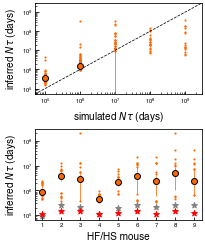

In [180]:
fig = plt.figure(figsize=(3, 4))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1,0.1,1])
bac_colors={'BWH2':KELLY_COLORS[0],
            'BtVPI':KELLY_COLORS[1],
            'Bovatus':KELLY_COLORS[2],
            'Bt7330':KELLY_COLORS[3]}
Ntau_lst = [10**5, 10**6, 10**7, 10**8, 10**9]

bac = 'Bovatus'

sim_dict = weighted9
emp_dict = emp_weighted9

if 'sim plots':
    ax = fig.add_subplot(gs[0, :])
    for x, Ntau in enumerate(Ntau_lst):
        drift_dict = sim_dict[bac][Ntau]
        slopes = []
        for key, fit in drift_dict.items():
            if fit[2][0] < 0:
                # slopes.append(1e-20)
                slopes.append(fit[2][0])
            else:
                slopes.append(fit[2][0])

        Ntaus = 8*np.array(slopes)**-1
        median = np.median(Ntaus)
        iqr_25 = np.percentile(Ntaus, 25)
        iqr_75 = np.percentile(Ntaus, 75)

        outliers = ((Ntaus > iqr_75) + (Ntaus < iqr_25))>0
        ax.scatter([Ntau]*outliers.sum(), Ntaus[outliers], color=bac_colors[bac], marker='.', s=5)
        ax.errorbar( [Ntau], [median], yerr=[[median-iqr_25],[iqr_75-median]], color=bac_colors[bac], mec='black', marker='o')
        # if median > 1e10:
        #     ax.arrow( Ntau*0.6, 10**9, 0, 10**9, head_width=100 )
        #     ax.scatter( [Ntau*0.6], 0.9*10**9, color=bac_colors[bac], marker='o')

    ax.set_xlim(1/2*10**5, 3*10**9)
    ax.set_ylim(1/2*10**5, 3*10**9)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='black', linestyle='dashed')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'simulated $N\tau$ (days)')
    ax.set_ylabel(r'inferred $N\tau$ (days)')

skip = []
if 'emp plots':
    ax = fig.add_subplot(gs[2, :])
    slopes = {mouse:[] for mouse in range(9)}

    seq_slopes = {mouse:[] for mouse in range(9)}
    all_slopes =[]
    for key, fit in emp_dict[bac].items():
        if key[0] in skip or key[1] in skip:
            continue
        if fit[2][0] < 0:
            slopes[key[0]].append(fit[2][0])
            slopes[key[1]].append(fit[2][0])
        else:
            slopes[key[0]].append(fit[2][0])
            slopes[key[1]].append(fit[2][0])
        all_slopes.append(fit[2][0])

        seq_slopes[key[0]].append(fit[2][1])
        seq_slopes[key[1]].append(fit[2][1])

    print(8*np.percentile(all_slopes, 25)**-1., 8*np.median(all_slopes)**-1., 8*np.percentile(all_slopes, 75)**-1.)

    index_mouse_map = {0:1, 1:2, 2:3, 3:5, 4:6, 5:7, 6:8, 7:9, 8:10}
    for mouse in range(9):
        if mouse in skip:
            continue
        mouse_slopes = slopes[mouse]
        print(len(mouse_slopes))
        mouse_Ntau = 8*np.array(mouse_slopes)**-1.
        median = np.median(mouse_Ntau)
        iqr_25 = np.percentile(mouse_Ntau, 25)
        iqr_75 = np.percentile(mouse_Ntau, 75)
        ax.errorbar( [mouse+1], [median], yerr=[[median-iqr_25],[iqr_75-median]], color=bac_colors[bac], marker='o', mec='black')

        outliers = ((mouse_Ntau > iqr_75) + (mouse_Ntau < iqr_25))>0
        ax.scatter([mouse+1]*outliers.sum(), mouse_Ntau[outliers], color=bac_colors[bac], marker='.', s=5)

        seq_depth = bac_read_arrays[bac][bac_row_ids[bac][(index_mouse_map[mouse],4)]][bac_nonwu_indices[bac]].sum()
        ax.scatter(mouse+1, seq_depth, color='grey', marker='*')
        ax.scatter(mouse+1, 2*np.median(seq_slopes[mouse])**-1., color='red', marker='*')
    ax.set_yscale('log')
    # ax.set_ylim(10**5, ax.get_ylim()[1])
    ax.set_xlabel(r'HF/HS mouse')
    ax.set_ylabel(r'inferred $N\tau$ (days)')

fig.savefig(f'drift_{bac}_demo.pdf')


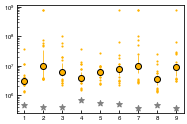

In [125]:
fig, ax = plt.subplots(figsize=(3,2))

bac = 'BWH2'
drift_dict = emp_weighted9[bac]
slopes = {mouse:[] for mouse in range(9)}
for key, fit in drift_dict.items():
    if fit[2][0] < 0:
        slopes[key[0]].append(1e-8)
        slopes[key[1]].append(1e-8)
    else:
        slopes[key[0]].append(fit[2][0])
        slopes[key[1]].append(fit[2][0])

index_mouse_map = {0:1, 1:2, 2:3, 3:5, 4:6, 5:7, 6:8, 7:9, 8:10}
for mouse in range(9):
    mouse_slopes = slopes[mouse]

    mouse_Ntau = 8*np.array(mouse_slopes)**-1.
    median = np.median(mouse_Ntau)
    iqr_25 = np.percentile(mouse_Ntau, 25)
    iqr_75 = np.percentile(mouse_Ntau, 75)
    ax.errorbar( [mouse+1], [median], yerr=[[median-iqr_25],[iqr_75-median]], color=bac_colors[bac], marker='o', mec='black')

    outliers = ((mouse_Ntau > iqr_75) + (mouse_Ntau < iqr_25))>0
    ax.scatter([mouse+1]*outliers.sum(), mouse_Ntau[outliers], color=bac_colors[bac], marker='.', s=5)

    seq_depth = bac_read_arrays[bac][bac_row_ids[bac][(index_mouse_map[mouse],4)]][bac_nonwu_indices[bac]].sum()
    ax.scatter(mouse+1, seq_depth, color='grey', marker='*')

ax.set_yscale('log')

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

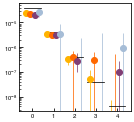

In [116]:
fig, ax = plt.subplots(figsize=(2, 2))
bac_colors={'BWH2':KELLY_COLORS[0],
            'BtVPI':KELLY_COLORS[1],
            'Bovatus':KELLY_COLORS[2],
            'Bt7330':KELLY_COLORS[3]}
Ntau_lst = [10**5, 10**6, 10**7, 10**8, 10**9]

bac = 'BWH2'
d = unweighted9
for x, Ntau in enumerate(Ntau_lst):
    for b, bac in enumerate(bacteria):
        drift_dict = d[bac][Ntau]

        slopes = []
        for key, fit in drift_dict.items():
            # if fit[2][1] == 0:
            #     continue
            slopes.append(fit[2][0])

        median = np.median(slopes)/2
        iqr_25 = np.percentile(slopes, 25)/2
        iqr_75 = np.percentile(slopes, 75)/2
        ax.errorbar( [x-0.3+b*0.2], [median], yerr=[[median-iqr_25],[iqr_75-median]], color=bac_colors[bac], marker='o')



    ax.plot([x-0.4, x+0.4], [4/Ntau, 4/Ntau], color='black')

ax.set_yscale('log')

ax.set_xticks(np.arange(len(Ntau_lst)))
ax.set_xticklabels([r'4/$10^5$', r'4/$10^6$', r'4/$10^7$', r'4/$10^8$'], fontsize=10)
ax.set_yticks(4/np.array(Ntau_lst))
ax.set_yticklabels([r'4/$10^5$', r'4/$10^6$', r'4/$10^7$', r'4/$10^8$'], fontsize=10)
# ax.set_xscale('log')
# ax.plot(ax.get_xlim(), ax.get_xlim())

# fig.savefig(f'{plot_dir}/paper_figures/demo_drift_sims.pdf')

BWH2 7.792901810797031e-06
Bovatus 1.3585863838433764e-05
BtVPI 1.4333922619350524e-05
Bt7330 3.619839236998833e-05


Text(0.5, 0, 'inferred log_10(N)')

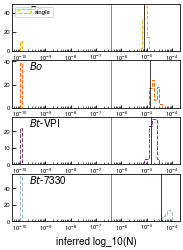

In [324]:
bac_colors={'BWH2':KELLY_COLORS[0],
            'BtVPI':KELLY_COLORS[1],
            'Bovatus':KELLY_COLORS[2],
            'Bt7330':KELLY_COLORS[3]}
fig, axs = plt.subplots(4, figsize=(3,4))

Ntau=10**7
for b, bac in enumerate(bacteria):
    x = []
    y = []
    x_grouped = []
    y_grouped = []
    for k, (key, inferences) in enumerate(grouped_drift_dict[bac][Ntau].items()):
    # for k, (key, inferences) in enumerate(grouped_weighted_drift_dict[bac][Ntau].items()):
    # for k, (key, inferences) in enumerate(grouped_odr_dict[bac][Ntau].items()):
    # for k, (key, inferences) in enumerate(individual_drift_dict[bac][Ntau].items()):

        # x.extend([m[0]]*len(inferences))
        if inferences[2][0] > 0:
            y.append( inferences[2][1] )
        else:
            y.append( 10**-10 )
        # y.append( inferences[1][0] )

        # y_grouped.extend(np.array(grouped_drift_dict[bac][key])/8)
        # ax.scatter([k]*len(inferences), inferences)
        # print(8/np.mean(drift_dict[bac])/10**5)
    # axs[0].scatter(x,y)
    # axs[b].hist(y)
    # axs[b].hist(-np.log10(y_grouped), bins=np.linspace(4, 8, 21), histtype='step', color=bac_colors[bac], label='grouped')
    axs[b].hist(y, bins=np.logspace(-10, -4, 61), histtype='step', linestyle='dashed', color=bac_colors[bac], label='single')
    axs[b].axvline( 4/Ntau )
    print(bac, np.mean(y))
    axs[b].axvline( np.mean(y), color='black')

    # axs[b].hist(y_grouped, histtype='step', color=bac_colors[bac], label='grouped')
    # axs[b].hist(y, histtype='step', linestyle='dashed', color=bac_colors[bac], label='single')
    axs[b].text(0.1, 0.8, BAC_FORMAL_NAMES[bac], transform=axs[b].transAxes)
    axs[b].set_xscale('log')

    if b == 0:
        axs[b].legend()
axs[3].set_xlabel('inferred log_10(N)')

# axs[0].set_yscale('log')

TypeError: unsupported operand type(s) for /: 'int' and 'tuple'

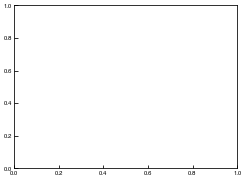

In [129]:
fig, ax = plt.subplots(figsize=(4, 3))
for bac in bacteria[1:2]:
    bac_inferredN_lst = []
    bac_inferredN_err = []
    bac_single_lst = []
    bac_sim_N_lst= []
    for N, inferredN_lst in drift_dict[bac].items():
        # if N != 10**6:
        #     continue
        # bac_inferredN_lst.extend(inferredN_lst)
        # bac_inferredN_err.extend( Ne_err_dict[bac][N] )
        grouped_Nlst = grouped_drift_dict[bac][N]
        bac_grouped_lst.append(np.mean)
        bac_inferredN_lst.append(np.mean(inferredN_lst))
        # bac_inferredN_err.append(np.std( Ne_err_dict[bac][N], ddof=1) )

        # bac_sim_N_lst += [8/N]*len(inferredN_lst)
        bac_sim_N_lst += [8/N]
    ax.errorbar(np.array(bac_sim_N_lst),
                bac_inferredN_lst,
                marker='o', mfc='none', label=f'{bac_formal_names[bac]}', linestyle='none')

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(10**4.5, 10**9.5)/
# ax.set_ylim(10**-9, 10**-4)
ax.plot(ax.get_xlim(), ax.get_xlim(), color='black', linestyle='dashed')

ax.set_title('Simulated Populations')
ax.set_xlabel(r'true N')
ax.set_ylabel(r'inferred N')
ax.legend()

fig.savefig(f'{plot_dir}/paper_figures/SI_simulated_Ntau.pdf')




In [ ]:
with open('30sim_fits_err.pkl', 'wb') as f:
    pickle.dump(bac_inferredN_lst, f)

with open('30sim_fits_slope_err.pkl', 'wb') as f:
    pickle.dump(bac_inferredN_err, f)

In [140]:
grouped_odr_dict['Bt7330']

{100000: {(0, 1, 7, 5, 8, 3, 4, 6, 2): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 1, 4, 8, 6, 5, 3, 7, 2): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 1, 3, 6, 8, 2, 7, 4, 5): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 2, 1, 8, 4, 5, 3, 7, 6): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 2, 4, 7, 1, 8, 6, 5, 3): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 2, 5, 7, 1, 4, 6, 3, 8): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]]))},
 1000000: {(0, 1, 6, 3, 8, 7, 4, 2, 5): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 1, 6, 5, 8, 2, 4, 3, 7): (0.0,
   -1,
   array([nan, nan]),
   array([[nan, nan],
          [nan, nan]])),
  (0, 1, 4, 3, 8, 2, 5, 6, 7): (0.0,
   -1,
   array([nan, nan]),
   array([[n

In [ ]:
fig, ax = plt.subplots()

real_x2 = real_x2[mask][where_finite]
mask2 = (~np.isnan(real_x2))
# x = x1 / x2
x = (real_x1[mask][where_finite]/real_x2)[mask2]
popt, pcov = scipy.optimize.curve_fit(lin, x, (y/x2)[mask2], p0=(10**-5, 10**-5), bounds=((0, 0), (np.inf, np.inf)))

x_min = np.min(x)
x_max = np.max(x)
ax.scatter(x, y/x2)
ax.plot( (x_min, x_max), lin(np.array([ x_min, x_max] ), popt[0], popt[1]), color='black')
print(popt[1])

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

fig, axs = plt.subplots(2, 4, figsize=(24, 12))

for n, N in enumerate(N_lst[::2]):
    Ne_lst = []
    Ne_err_lst = []

    fitnesses, sorted_indices = generate_empirical_ordered_fitnesses(bac, bc, [6, 7, 8, 9, 10])
    sigma = 0.1 #add jitter to fitnesses
    fitnesses = fitnesses + rnd.normal(loc=0, scale=sigma, size = len(fitnesses)) #
    fitnesses[ fitnesses > 1 ] = 1

    init_freqs = freq_dict[bac][bc][-1][sorted_indices]
    init_reads = read_dict[bac][bc][-1][sorted_indices]

    sim_freqs = sim_population_frequencies(init_freqs, fitnesses, gens=4, N=N, num_populations=5, D=10**5.5)

    where_finite = init_reads > 10
    rank_lfcs = np.log( (np.mean(sim_freqs[:-1], axis=0)[where_finite]) / (init_freqs[where_finite]) ) / 4
    rank_order = np.argsort(rank_lfcs)[::-1]
    test_lfcs = np.log( (sim_freqs[-1][where_finite]) / (init_freqs[where_finite])) / 4
    sorted_lfcs = test_lfcs[rank_order]

    lfc_ax = axs[0, n]
    lfc_ax.scatter( np.arange(rank_order.shape[-1])[:20000], sorted_lfcs[:20000], rasterized=True, s=1.0)

    Ne, Ne_err, intercept, intercept_err, all_x, all_y = group_barcodes_across_read_ranges(init_reads, init_freqs, sim_freqs, read_ranges, start=start, min_group_size=min_group_size, min_freq_ratio=min_freq_ratio)
    xy_ax = axs[1, n]
    xy_ax.scatter(all_x, all_y, rasterized=True)
    if n == 0:
        xy_ax.set_xlabel('g[P(s)]/H')
        xy_ax.set_ylabel('Var(f1-f2)/H')
        lfc_ax.set_xlabel('fitness rank')
        lfc_ax.set_ylabel('validation fitness')

    lfc_ax.set_title(fr'N=$10^{int(np.log10(N))}$')

fig.savefig(f'{plot_dir}/drift/simulated_variance_vs_g')

In [ ]:
fig, lfc_ax  = plt.subplots(figsize=(30, 6))
lfc_ax.scatter( np.arange(rank_order.shape[-1])[:20000], sorted_lfcs[:20000], rasterized=True, s=1.0)